In [1]:
import os, nltk
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random
import numpy as np
from mlxtend.evaluate import permutation_test
import pingouin as pg
import statsmodels.formula.api as smf
import ndtest
import glasbey

In [2]:
# Set experiment seed and parameters
GENERAL_SEED = 42
random.seed(GENERAL_SEED)
np.random.seed(GENERAL_SEED)

SAVE_images = True

gpt2_wiki2_ppl  = 29.41

In [3]:
testing_model = 'gpt2'
testing_model_prnt_name = 'GPT2' if 'OLMo' not in testing_model else testing_model
testing_variables = f"{testing_model}_perplexities"

In [4]:
dataset_df_test = pd.read_csv('Wiki_no_title_reduced_DreamBank_reduced_en_pptx_multiGPT.csv')

dataset_df_test = dataset_df_test[dataset_df_test["Data"].isin(["DreamBank"])]
dataset_df_test = dataset_df_test.reset_index(drop=True)

dataset_df_test["Below_WT2t_ppl"] = [
    1 if v > gpt2_wiki2_ppl else 0 for v in tqdm(dataset_df_test[testing_variables])
]

dataset_df_test["vision"] = [
    "impaired" if "blind" in series_id else "normal"
    for series_id in tqdm(dataset_df_test["series"])
]

dataset_df_test["Clinical (PTSD)"] = [
    "Yes" if s == "vietnam_vet" else "No" for s in tqdm(dataset_df_test["series"])
]

100% 13737/13737 [00:00<00:00, 3311521.01it/s]
100% 13737/13737 [00:00<00:00, 3453851.70it/s]
100% 13737/13737 [00:00<00:00, 3324130.51it/s]


In [5]:
n = 100*len(dataset_df_test[dataset_df_test[testing_variables] <= gpt2_wiki2_ppl])/len(dataset_df_test)

print("{:.2f}%: dream reports with a PPL score lower than WikiText2 (test),".format(n))

36.43%: dream reports with a PPL score lower than WikiText2 (test),


## Statistical modelling
#### Logit

In [6]:
# statsmodels API does not like .
dataset_df_test["NoWords"] = dataset_df_test["No.Words"]

log_reg = smf.logit(
     "Below_WT2t_ppl ~ gender + NoWords + vision + vision:NoWords + NoWords:gender + gender:vision",
      data=dataset_df_test,
).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.626633
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         Below_WT2t_ppl   No. Observations:                13737
Model:                          Logit   Df Residuals:                    13730
Method:                           MLE   Df Model:                            6
Date:                Wed, 06 Nov 2024   Pseudo R-squ.:                 0.04459
Time:                        15:23:53   Log-Likelihood:                -8608.1
converged:                       True   LL-Null:                       -9009.8
Covariance Type:            nonrobust   LLR p-value:                2.773e-170
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.4795      0.333      4.436  

(Text(0.5, 6.8833333333333275, 'Predicted'),
 Text(34.08333333333333, 0.5, 'True'))

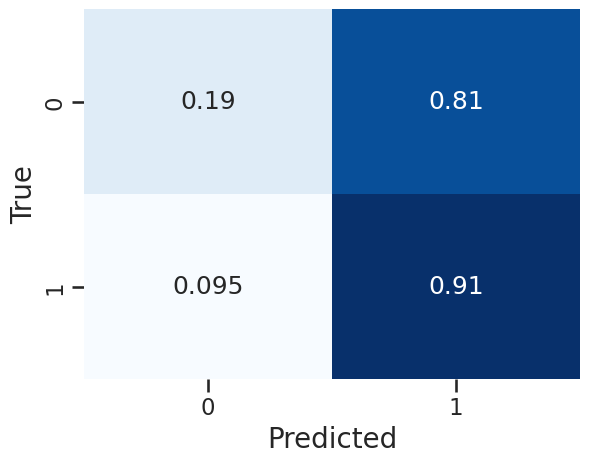

In [7]:
pred_tab = log_reg.pred_table()
row_sums = pred_tab.sum(axis=1)
pred_tab_norm = pred_tab / row_sums[:, np.newaxis]

sns.set_theme(context='talk', style='ticks')
g = sns.heatmap(
    pred_tab_norm,
    annot=True,
    cmap="Blues",
    cbar=False
)

g.set_xlabel("Predicted",size=20), g.set_ylabel("True",size=20)

#### Linear

In [8]:
 mod = smf.ols(
    f"{testing_variables} ~ gender + NoWords + vision + gender:NoWords:vision",
    data=dataset_df_test,
)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      gpt2_perplexities   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     330.8
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:23:53   Log-Likelihood:                -64029.
No. Observations:               13737   AIC:                         1.281e+05
Df Residuals:                   13730   BIC:                         1.281e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## Gender

In [9]:
palette_gndr = 'Set3_r'

/tmp/ipykernel_3123/1371013257.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend().remove()


(Text(0, 0.5, 'Count'), Text(0.5, 0, 'Gender'))

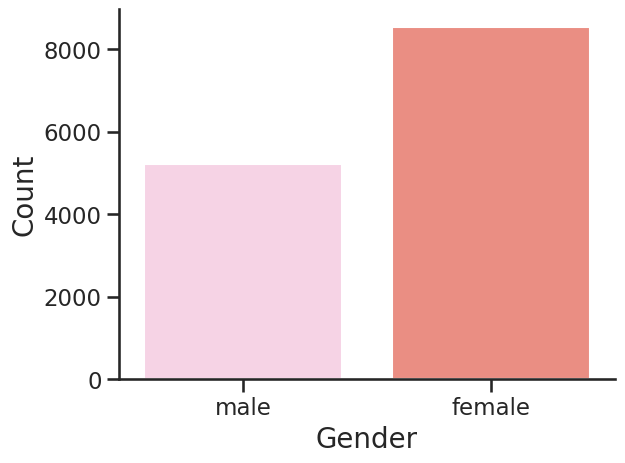

In [10]:
sns.set_theme(context='talk', style='ticks')
g = sns.countplot(
    data=dataset_df_test,
    x="gender",
    hue="gender",
    dodge=False,
    palette=palette_gndr
)
# g.set_ylim(6000)
g.legend().remove()
sns.despine()
g.set_ylabel("Count",size=20), g.set_xlabel("Gender",size=20)

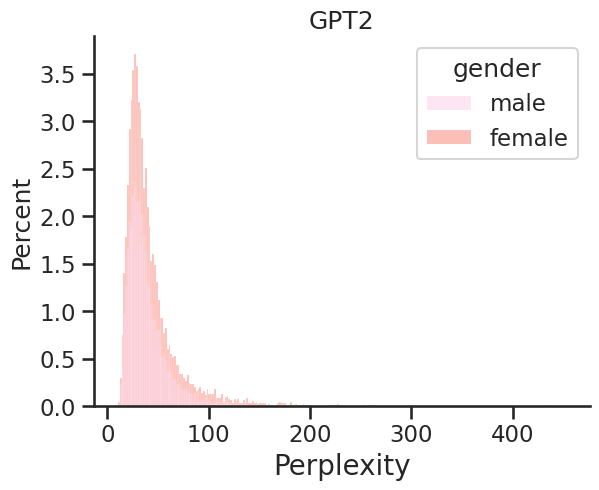

In [11]:
sns.set_theme(context='talk', style='ticks')

g = sns.histplot(
    data=dataset_df_test,
    x=testing_variables,
    hue="gender",
    stat='percent',
    palette=palette_gndr,
)

sns.despine()
g.set_xlabel("Perplexity",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/db_ppl_gender_hist_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

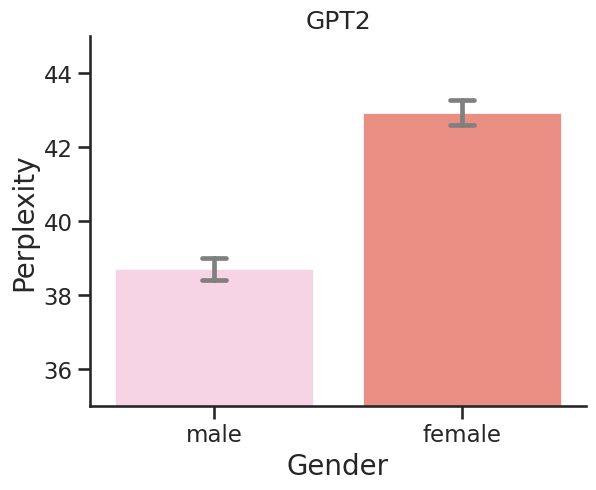

In [12]:
sns.set_theme(context='talk', style='ticks')
g = sns.barplot(
    data=dataset_df_test,
    y=testing_variables,
    x="gender",
    hue="gender",
    dodge=False,
    palette=palette_gndr,
    capsize=.1,
    linewidth=.5,
    err_kws={'color': '.5'},
    errorbar=("se", 1)
)

g.set_ylim(35, 45)
sns.despine()
g.set_ylabel("Perplexity",size=20), g.set_xlabel("Gender",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/db_ppl_gender_bar_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

/tmp/ipykernel_3123/3192577776.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g_right = sns.boxplot(
/tmp/ipykernel_3123/3192577776.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g_left = sns.boxplot(
/tmp/ipykernel_3123/3192577776.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g_right.set_xticklabels(


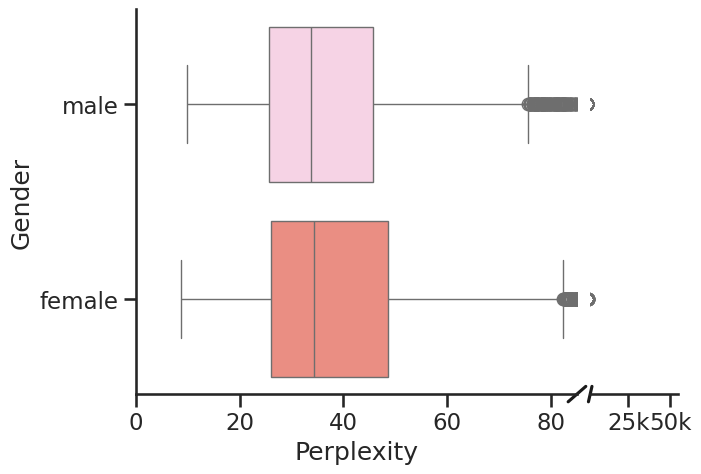

In [13]:
sns.set_theme(context='talk', style='ticks')
f, (ax_left, ax_right) = plt.subplots(
    ncols=2,
    nrows=1,
#     sharey=True,
    gridspec_kw={'wspace':0.05, 'width_ratios': [5, 1]},
    figsize=(7,5)
)

ax_right.figsize = (2, 2)
g_right = sns.boxplot(
    data=dataset_df_test,
    x=testing_variables,
    y="gender",
    order=["male", "female"],
    palette=palette_gndr,
    ax=ax_right,
    dodge=False,
)

g_right.set_xlim(2000, 55000)
sns.despine(ax=g_right)

g_left = sns.boxplot(
    data=dataset_df_test,
    x=testing_variables,
    y="gender",
    order=["male", "female"],
    palette=palette_gndr,
    ax=ax_left,
    dodge=False,
)

sns.despine(ax=ax_left)
g_left.set_xlabel(""), g_right.set_xlabel("")
g_left.set_xlim(0,85)
g_right.axes.get_yaxis().set_visible(False)
sns.despine(ax=g_right, left=True)

g_right.set_xticklabels(
    ["{}k".format(str(x/1000).replace(".0", "")) for x in g_right.get_xticks()]
)

ax = ax_right
d = .020  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_left
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-left diagonal
g.set(title=testing_model_prnt_name)
g_left.set_ylabel("Gender"), g_left.set_xlabel("Perplexity")
plt.show()

In [14]:
gender_ppl_p = permutation_test(
    dataset_df_test[dataset_df_test["gender"].isin(["male"])][testing_variables],
    dataset_df_test[dataset_df_test["gender"].isin(["female"])][testing_variables],
    method='approximate',
    num_rounds=10000,
    seed=0
)

gender_ppl_p

9.999000099990002e-05

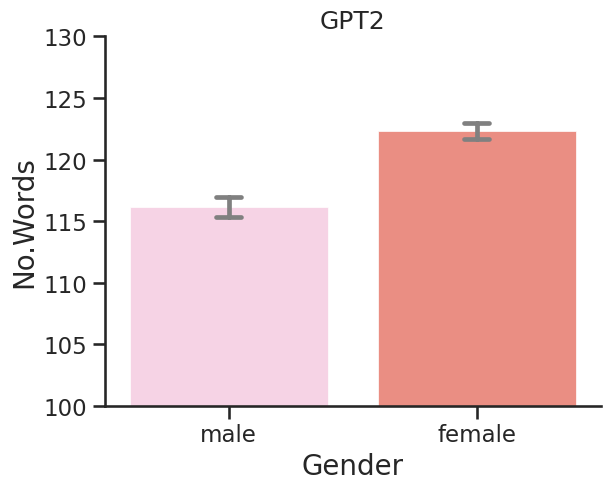

In [15]:
sns.set_theme(context='talk', style='ticks')
g = sns.barplot(
    data=dataset_df_test,
    y="No.Words",
    x="gender",
    hue="gender",
    dodge=False,
    palette="Set3_r",
    capsize=.1,
    err_kws={'color': '.5'},
    linewidth=.5,
    errorbar=("se", 1)
)

g.set_ylim(100, 130)
sns.despine()
g.set_ylabel("No.Words",size=20), g.set_xlabel("Gender",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/db_nw_gender_bar_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight',
    )

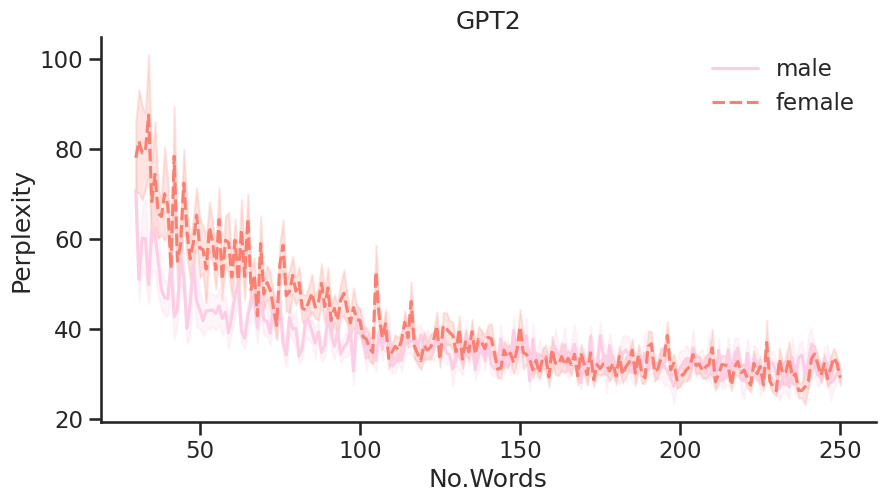

In [16]:
sns.set_theme(context='talk', style='ticks')
plt.figure(figsize=(10,5))

g = sns.lineplot(
    data=dataset_df_test,
    y=testing_variables,
    x="No.Words",
    hue="gender",
    errorbar=("se", 1),
    palette="Set3_r",
    style="gender",
#     hue_order=["male", "female"]
)

g.set(ylabel="Perplexity")
sns.despine(top=True, right=True)
plt.legend(frameon=False)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/nowds_ppl_lineplot_gender_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [17]:
# Statistical analysis: Peacock test
ml_nwd, ml_ppl = zip(*dataset_df_test[
    dataset_df_test["gender"].isin(["male"])
][["No.Words", testing_variables]].values)

fm_nwd, fm_ppl = zip(*dataset_df_test[
    dataset_df_test["gender"].isin(["female"])
][["No.Words", testing_variables]].values)

# 2D KS
Peacock_p_gender, Peacock_D_gender = ndtest.ks2d2s(ml_nwd, ml_ppl, fm_nwd, fm_ppl, extra=True)
print(f"{Peacock_p_gender=:.5g}, {Peacock_D_gender=:.3g}")

Peacock_p_gender=7.8734e-15, Peacock_D_gender=0.0877


In [18]:
gender_nw_p = permutation_test(
    dataset_df_test[dataset_df_test["gender"].isin(["male"])]["No.Words"],
    dataset_df_test[dataset_df_test["gender"].isin(["female"])]["No.Words"],
    method='approximate',
    num_rounds=10000,
    seed=0
)

gender_nw_p

9.999000099990002e-05

## Series

/tmp/ipykernel_3123/1122654116.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticks(), size = 15)


[Text(0.5, 1.0, 'GPT2')]

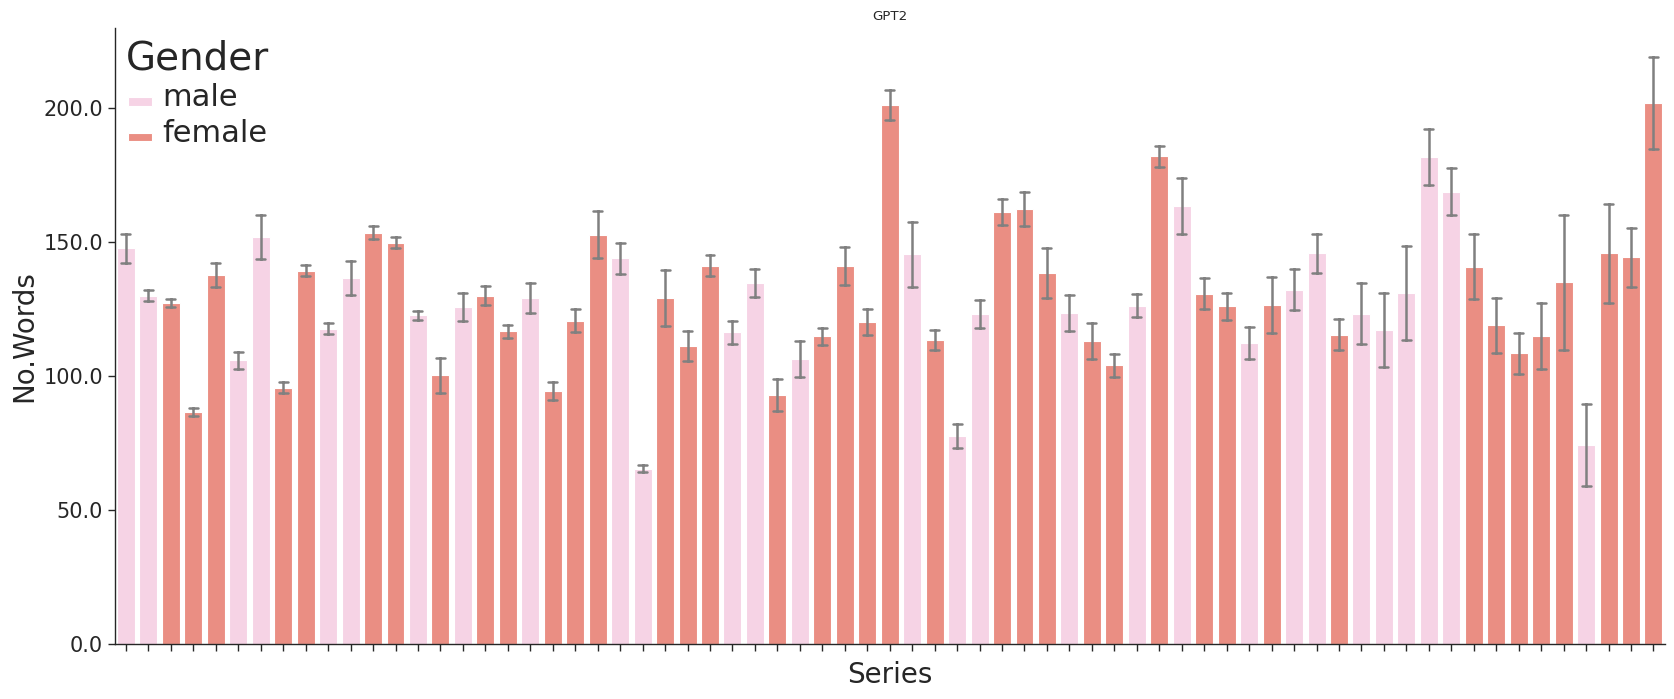

In [19]:
sns.set_theme(context='paper', style='ticks')

plt.figure(figsize=(20,8))
g = sns.barplot(
    data=dataset_df_test,
    y="No.Words",
    x="series",
    hue="gender",
    dodge=False,
    palette="Set3_r",
    capsize=.4,
    err_kws={'color': '.5'},
    errorbar=("se", 1),
)

g.set(xticklabels=[])
g.set_ylabel("No.Words",size=20), g.set_xlabel("Series",size=20)
g.set_yticklabels(g.get_yticks(), size = 15)
g.legend(title="Gender", frameon=False)
plt.setp(g.get_legend().get_texts(), fontsize='22')
plt.setp(g.get_legend().get_title(), fontsize='28')
sns.despine()
g.set(title=testing_model_prnt_name)

In [20]:
rho_series_nw, p_series_nw = stats.spearmanr(
    dataset_df_test["series"],
    dataset_df_test["No.Words"]
)

rho_series_nw, p_series_nw

(-0.06633173888345409, 7.123353092170165e-15)

/tmp/ipykernel_3123/2356036136.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticks(), size = 15)


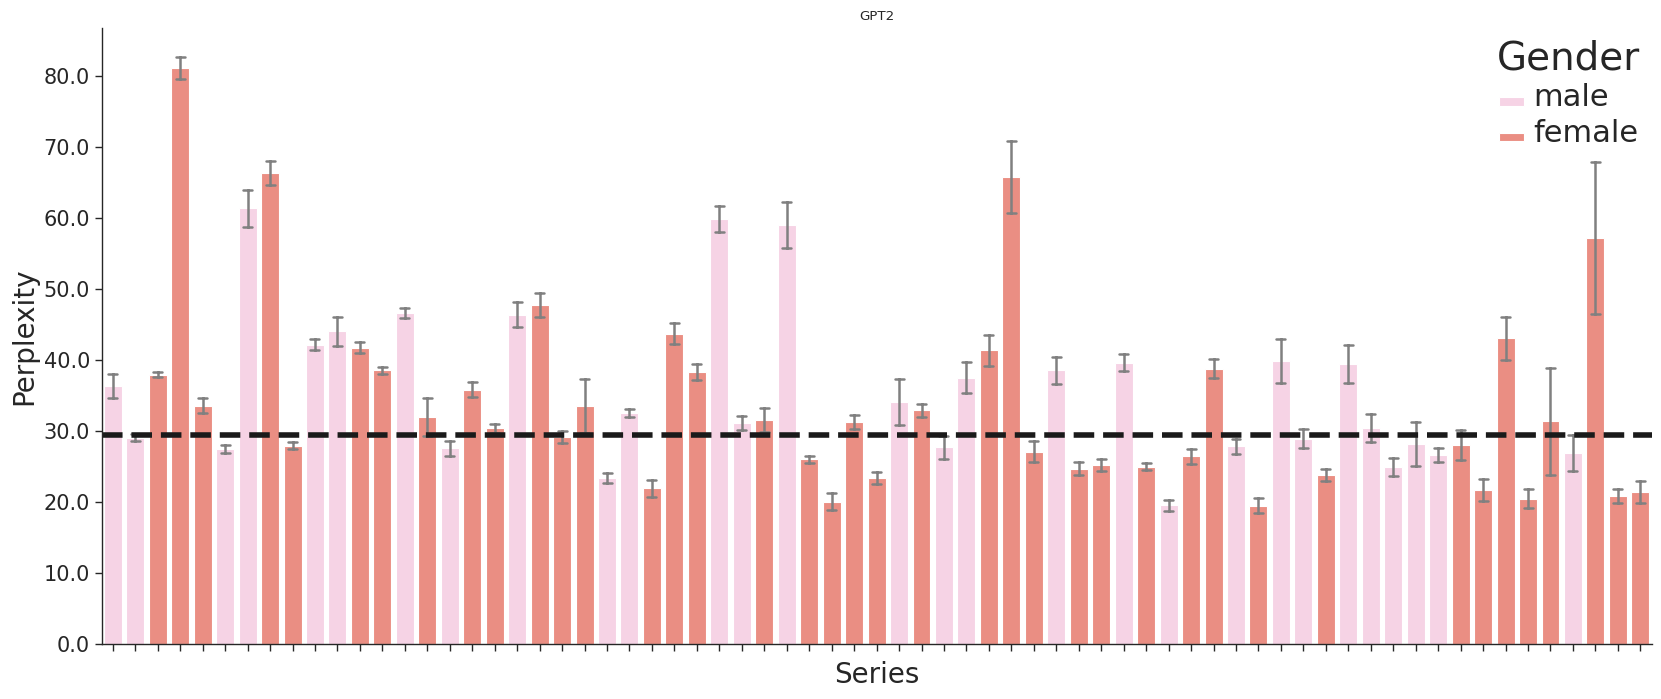

In [21]:
sns.set_theme(context='paper', style='ticks')

plt.figure(figsize=(20,8))
g = sns.barplot(
    data=dataset_df_test,
    y=testing_variables,
    x="series",
    hue="gender",
    dodge=False,
    palette="Set3_r",
    capsize=.4,
    err_kws={'color': '.5'},
    errorbar=("se", 1),
)

g.set(xticklabels=[])
g.set_ylabel("Perplexity",size=20), g.set_xlabel("Series",size=20)
g.set_yticklabels(g.get_yticks(), size = 15)
g.legend(title="Gender", frameon=False)
plt.axhline(gpt2_wiki2_ppl, color='k', linestyle="--", linewidth=4)
plt.setp(g.get_legend().get_texts(), fontsize='22')
plt.setp(g.get_legend().get_title(), fontsize='28')
sns.despine()
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/series_perplexity_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [22]:
df = dataset_df_test.groupby("series")[testing_variables].describe()
n_dreams_in_below_series   = 0
series_with_low_ppl_dreams = []
for index , row in enumerate(df.values):
    count, p_mean, p_std, p_min, p_25, p_50, p_75, p_max = row
    stnd_e = p_std / np.sqrt(count)
    series = df.index[index]
    if ((p_mean - stnd_e) <= gpt2_wiki2_ppl) and (stnd_e < gpt2_wiki2_ppl):
        series_with_low_ppl_dreams.append(series)
        print("{} ({}): {} ± {}".format(series, int(count), round(p_mean,2), round(p_std,2)))
        n_dreams_in_below_series += count

print(int(100*len(series_with_low_ppl_dreams)/len(set(list(dataset_df_test["series"])))))
print(round(100*n_dreams_in_below_series/len(dataset_df_test), 1))

angie (31): 20.81 ± 5.59
bea2 (39): 27.08 ± 8.9
blind-f (173): 29.14 ± 11.01
blind-m (112): 27.85 ± 11.13
chuck (54): 28.88 ± 9.58
dahlia (19): 20.45 ± 5.98
ed (98): 23.39 ± 6.95
edna (8): 31.33 ± 21.19
jasmine1 (21): 28.01 ± 9.81
jasmine2 (124): 24.96 ± 5.93
jasmine3 (39): 23.4 ± 5.29
jasmine4 (13): 21.43 ± 5.48
jeff (36): 26.58 ± 5.72
joan (28): 19.46 ± 5.67
mack (25): 30.4 ± 9.89
mark (11): 26.87 ± 8.25
melissa (73): 24.66 ± 7.68
midwest_teens-f (101): 25.21 ± 8.14
midwest_teens-m (57): 27.66 ± 11.84
nancy (34): 21.89 ± 6.83
norms-f (423): 27.93 ± 9.24
norms-m (433): 29.04 ± 11.09
peru-f (291): 26.02 ± 8.28
peru-m (309): 27.47 ± 9.33
phil3 (129): 27.53 ± 11.5
ringo (12): 24.85 ± 4.39
seventh_graders (50): 20.01 ± 8.55
toby (13): 28.14 ± 11.11
tom (19): 19.5 ± 3.56
ucsc_women (65): 26.44 ± 8.51
vickie (28): 21.72 ± 8.25
wedding (55): 31.98 ± 19.64
west_coast_teens (75): 23.76 ± 7.56
47
21.8


In [23]:
rho_series_ppl, p_series_ppl = stats.spearmanr(
    dataset_df_test["series"],
    dataset_df_test[testing_variables]
)
rho_series_ppl, p_series_ppl

(-0.15050752979700663, 2.0682695212716556e-70)

## Year

In [24]:
year_cov = {}
for y in set(dataset_df_test["year"]):
    try:
        seq = [int(x) for x in y.replace("s", "").split("-")]
        new_y = int(sum(seq)/len(seq))
    except:
        new_y = "do manual"
    year_cov[y] = new_y

In [25]:
year_cov = {
 '1897-1918': 1907,
 '1912-1965': 1938,
 '1939': 1939,
 '1940-1998': 1969,
 '1940s-1950s': 1945,
 '1940s-1950s & 1990s': 1960,
 '1946-1950': 1948,
 '1948-1949': 1948,
 '1949-1964': 1956,
 '1949-1997': 1973,
 '1957-1959': 1958,
 '1960-1997': 1978,
 '1960-1999': 1979,
 '1962': 1962,
 '1963-1965': 1964,
 '1963-1967': 1965,
 '1964': 1964,
 '1968': 1968,
 '1970': 1970,
 '1970-2008': 1989,
 '1971': 1971,
 '1980-2002': 1991,
 '1985-1997': 1991,
 '1990-1999': 1994,
 '1990s': 1990,
 '1991-1993': 1992,
 '1992-1998': 1995,
 '1992-1999': 1995,
 '1995': 1995,
 '1996': 1996,
 '1996-1997': 1996,
 '1996-1998': 1997,
 '1997': 1997,
 '1997-1999': 1998,
 '1997-2000': 1998,
 '1997-2001': 1999,
 '1998': 1998,
 '1998-2000': 1999,
 '1999-': 2010,
 '1999-2000': 1999,
 '1999-2001': 2000,
 '2000': 2000,
 '2000-2001': 2000,
 '2001-2003': 2002,
 '2003-2004': 2003,
 '2003-2005': 2004,
 '2003-2006': 2004,
 '2004': 2004,
 '2007-2010': 2008,
 '2009': 2009,
 '2010-2011': 2010,
 '?': np.NaN,
 'late 1990s': 1998,
 'mid-1980s': 1985,
 'mid-1990s': 1995
}

In [26]:
dataset_df_test["year_av"] = [year_cov[x] for x in tqdm(dataset_df_test["year"])]
dataset_df_test_year       = dataset_df_test.dropna().reset_index(drop=True)

100% 13737/13737 [00:00<00:00, 3363523.30it/s]


In [27]:
 mod = smf.ols(
    f"{testing_variables} ~ gender + NoWords + year_av + gender:NoWords:year_av",
    data=dataset_df_test_year,
)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      gpt2_perplexities   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     462.9
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:24:24   Log-Likelihood:                -63656.
No. Observations:               13685   AIC:                         1.273e+05
Df Residuals:                   13679   BIC:                         1.274e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [28]:
rho_yearAv_ppl, p_yearAv_ppl = stats.spearmanr(
    dataset_df_test_year["year_av"],
    dataset_df_test_year[testing_variables]
)
rho_yearAv_ppl, p_yearAv_ppl

(-0.13236956708847414, 1.5412134165014697e-54)

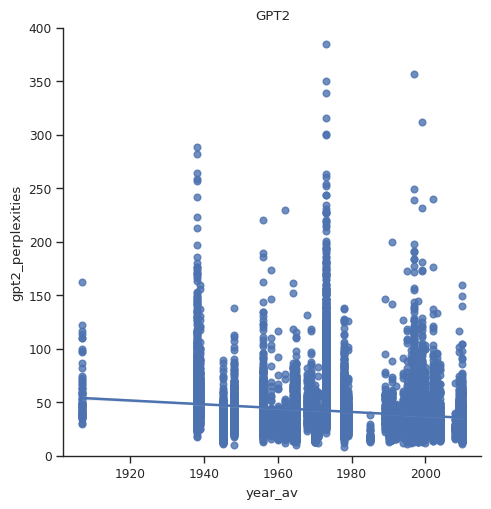

In [29]:
sns.set_theme(context='paper', style='ticks')
g = sns.lmplot(
    data=dataset_df_test_year,
    y=testing_variables,
    x="year_av",
)

g.set(ylim=(0, 400))
sns.despine()
g.set(title=testing_model_prnt_name)

## Visual Impairment



In [30]:
dataset_df_test_impaired = dataset_df_test[dataset_df_test["vision"].isin(["impaired"])]

In [31]:
dataset_df_test_impaired[testing_variables].describe()

count    285.000000
mean      28.630266
std       11.058746
min       13.514583
25%       21.478155
50%       26.737467
75%       32.539120
max      109.136383
Name: gpt2_perplexities, dtype: float64

In [32]:
dataset_df_test_normal_all = dataset_df_test[~dataset_df_test["vision"].isin(["impaired"])]

dataset_df_test_normal_all = dataset_df_test_normal_all[
    dataset_df_test_normal_all[testing_variables] <= 125
]

dataset_df_test_normal_all = dataset_df_test_normal_all[
    dataset_df_test_normal_all[testing_variables] >= 13
]

In [33]:
dataset_df_test_normal_s = dataset_df_test_normal_all.sample(len(dataset_df_test_impaired))
dataset_df_test_II       = pd.concat([dataset_df_test_impaired, dataset_df_test_normal_s])

In [34]:
vsn_palett = "Set2_r"

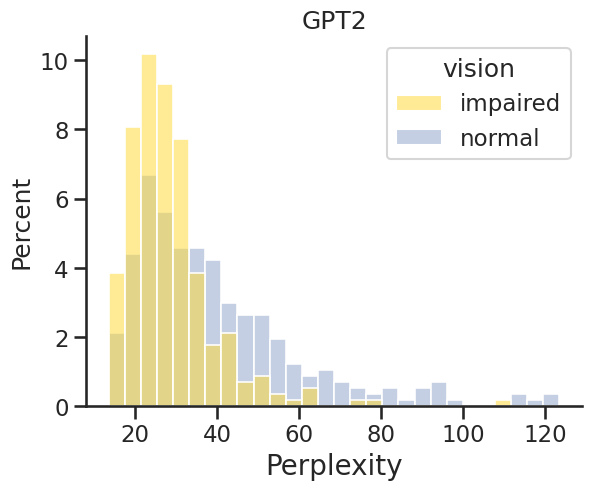

In [35]:
sns.set_theme(context='talk', style='ticks')

g = sns.histplot(
    data=dataset_df_test_II,
    x=testing_variables,
    hue="vision",
    palette=vsn_palett,
    stat='percent',
)

sns.despine()
g.set_xlabel("Perplexity",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/blind_normal_hist_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

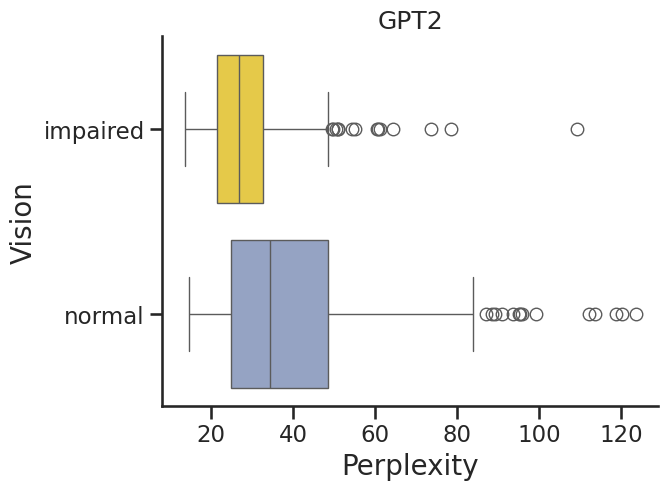

In [36]:
sns.set_theme(context='talk', style='ticks')

g = sns.boxplot(
    data=dataset_df_test_II,
    x=testing_variables,
    y="vision",
    hue="vision",
    palette=vsn_palett
)

sns.despine()
g.set_ylabel("Vision",size=20), g.set_xlabel("Perplexity",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/blind_normal_box_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [37]:
vision_ppl_p = permutation_test(
    dataset_df_test_impaired[testing_variables],
    dataset_df_test_normal_s[testing_variables],
    method='approximate',
    num_rounds=10000,
    seed=0
)

print(format(vision_ppl_p, '.8f'))

0.00009999


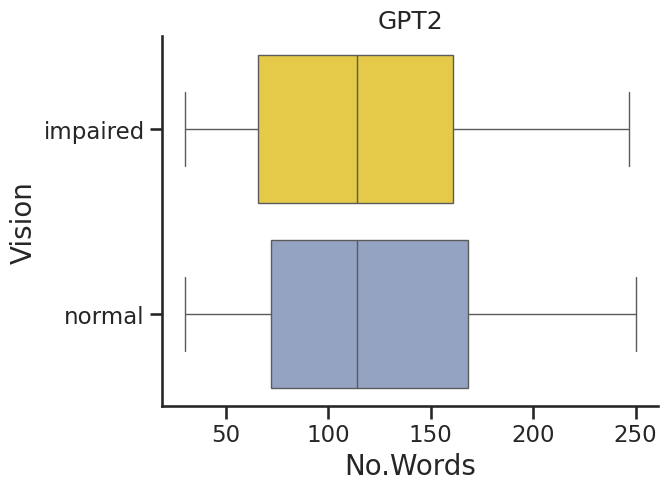

In [38]:
sns.set_theme(context='talk', style='ticks')

g = sns.boxplot(
    data=dataset_df_test_II,
    x="No.Words",
    y="vision",
    hue="vision",
    palette=vsn_palett
)

sns.despine()
g.set_ylabel("Vision",size=20), g.set_xlabel("No.Words",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/blind_normal_box_nw_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [39]:
vision_nw_p = permutation_test(
    dataset_df_test_impaired["No.Words"],
    dataset_df_test_normal_s["No.Words"],
    method='approximate',
    num_rounds=10000,
    seed=0
)

print(format(vision_nw_p, '.8f'))

0.27107289


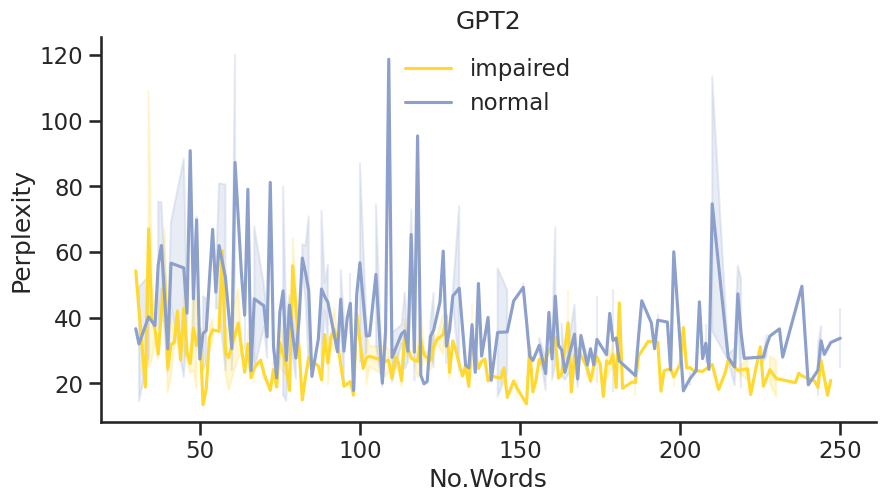

In [40]:
sns.set_theme(context='talk', style='ticks')
plt.figure(figsize=(10,5))

g = sns.lineplot(
    data=dataset_df_test_II,
    y=testing_variables,
    x="No.Words",
    hue="vision",
    palette=vsn_palett,
    errorbar=("se", 1),
)

g.set(ylabel="Perplexity")
sns.despine(top=True, right=True)
plt.legend(frameon=False)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/nowds_ppl_lineplot_vision_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [41]:
# Statistical analysis: Peacock test
im_nwd, im_ppl = zip(*dataset_df_test_II[
    dataset_df_test_II["vision"].isin(["impaired"])
][["No.Words", testing_variables]].values)

nm_nwd, nm_ppl = zip(*dataset_df_test_II[
    dataset_df_test_II["vision"].isin(["normal"])
][["No.Words", testing_variables]].values)

# 2D KS
Peacock_p_vision, Peacock_D_vision = ndtest.ks2d2s(im_nwd, im_ppl, nm_nwd, nm_ppl, extra=True)
print(f"{Peacock_p_vision=:.5g}, {Peacock_D_vision=:.3g}")

Peacock_p_vision=2.5014e-09, Peacock_D_vision=0.316


## Clinical subject (PTSD)

In [42]:
dataset_df_test_ptsd = dataset_df_test[dataset_df_test["Clinical (PTSD)"].isin(["Yes"])]

dataset_df_test_ptsd[testing_variables].describe()

count     75.000000
mean      43.994586
std       18.074044
min       22.436565
25%       32.840498
50%       39.397778
75%       52.933416
max      147.051407
Name: gpt2_perplexities, dtype: float64

In [43]:
dataset_df_test_hlth_all = dataset_df_test[~dataset_df_test["Clinical (PTSD)"].isin(["Yes"])]

dataset_df_test_hlth_all = dataset_df_test_hlth_all[
    dataset_df_test_hlth_all[testing_variables] <= 147
]

dataset_df_test_hlth_all = dataset_df_test_hlth_all[
    dataset_df_test_hlth_all[testing_variables] >= 22
]

In [44]:
dataset_df_test_hlth_s = dataset_df_test_hlth_all.sample(len(dataset_df_test_ptsd))
dataset_df_test_III    = pd.concat(
    [
    dataset_df_test_ptsd,
    dataset_df_test_hlth_s
    ]
).reset_index(drop=True)

In [45]:
hlth_palette = 'Paired_r'

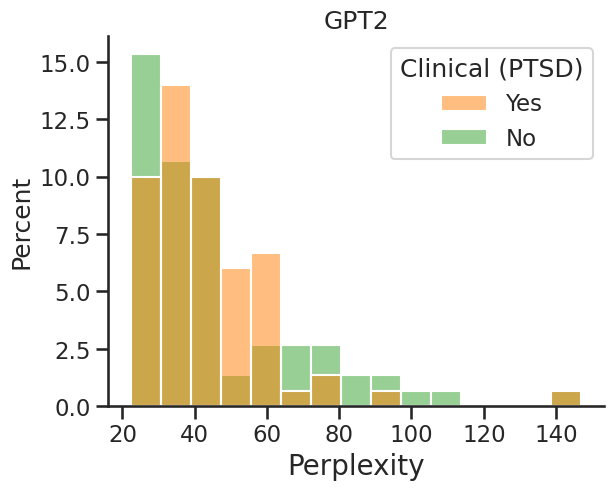

In [46]:
sns.set_theme(context='talk', style='ticks')

g = sns.histplot(
    data=dataset_df_test_III,
    x=testing_variables,
    hue="Clinical (PTSD)",
    palette=hlth_palette,
    stat='percent',
)

sns.despine()
g.set_xlabel("Perplexity",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/hlth_normal_hist_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

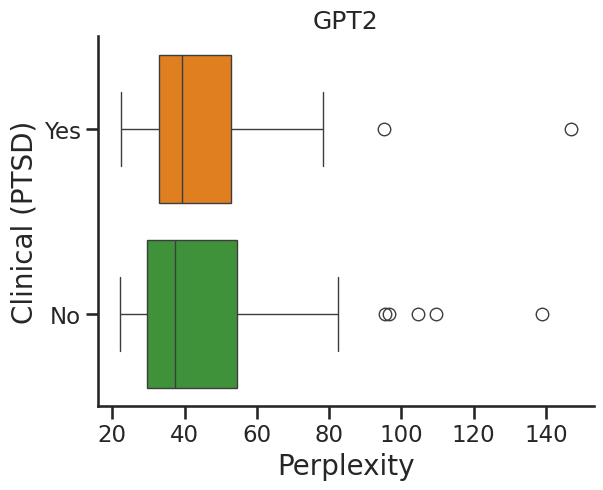

In [47]:
sns.set_theme(context='talk', style='ticks')

g = sns.boxplot(
    data=dataset_df_test_III,
    x=testing_variables,
    y="Clinical (PTSD)",
    hue="Clinical (PTSD)",
    palette=hlth_palette,
)

sns.despine()
g.set_ylabel("Clinical (PTSD)",size=20), g.set_xlabel("Perplexity",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/clinical_hlth_box_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )


In [48]:
hlth_ppl_p = permutation_test(
    dataset_df_test_ptsd[testing_variables],
    dataset_df_test_hlth_s[testing_variables],
    method='approximate',
    num_rounds=10000,
    seed=0
)

print(format(hlth_ppl_p, '.8f'))

0.64073593


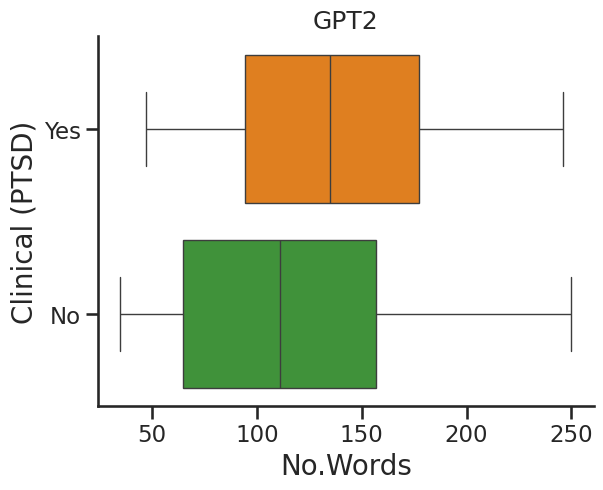

In [49]:
sns.set_theme(context='talk', style='ticks')

g = sns.boxplot(
    data=dataset_df_test_III,
    x="No.Words",
    y="Clinical (PTSD)",
    hue="Clinical (PTSD)",
    palette=hlth_palette,
)

sns.despine()
g.set_ylabel("Clinical (PTSD)",size=20), g.set_xlabel("No.Words",size=20)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/clinical_hlth_box_nw_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [50]:
hlth_nw_p = permutation_test(
    dataset_df_test_ptsd["No.Words"],
    dataset_df_test_hlth_s["No.Words"],
    method='approximate',
    num_rounds=10000,
    seed=0
)

print(format(hlth_nw_p, '.8f'))

0.03129687


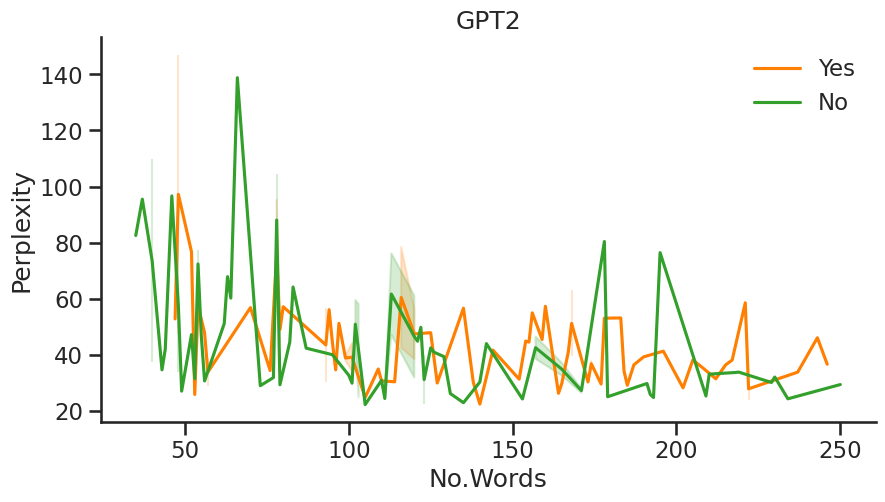

In [51]:
sns.set_theme(context='talk', style='ticks')
plt.figure(figsize=(10,5))

g = sns.lineplot(
    data=dataset_df_test_III,
    y=testing_variables,
    x="No.Words",
    hue="Clinical (PTSD)",
    palette=hlth_palette,
    errorbar=("se", 1),
)

g.set(ylabel="Perplexity")
sns.despine(top=True, right=True)
plt.legend(frameon=False)
g.set(title=testing_model_prnt_name)

if SAVE_images:
    plt.savefig(
        f"Images/nowds_ppl_lineplot_hlth_{testing_model}.pdf",
        dpi=400,
        bbox_inches='tight'
    )

In [52]:
# Statistical analysis: Peacock test
im_nwd, im_ppl = zip(*dataset_df_test_III[
    dataset_df_test_III["Clinical (PTSD)"].isin(["Yes"])
][["No.Words", testing_variables]].values)

nm_nwd, nm_ppl = zip(*dataset_df_test_III[
    dataset_df_test_III["Clinical (PTSD)"].isin(["No"])
][["No.Words", testing_variables]].values)

# 2D KS
Peacock_p_hlth, Peacock_D_hlth = ndtest.ks2d2s(im_nwd, im_ppl, nm_nwd, nm_ppl, extra=True)
print(f"{Peacock_p_hlth=:.5g}, {Peacock_D_hlth=:.3g}")

Peacock_p_hlth=0.018025, Peacock_D_hlth=0.28


## Save stats

In [53]:
p_val_ls = [
    ["Gender-PPL-permutation", gender_ppl_p, '', ''],
    ["Gender-NW-permutation", gender_nw_p, '', ''],
    ["Series-PPL-correlation", p_series_ppl, '', rho_series_ppl],
    ["Series-NW-correlation", p_series_nw, '', rho_series_nw],
    ["YearAv-PPL-correlation", p_yearAv_ppl, '', rho_yearAv_ppl],
    ["Vision-PPL-permutation", vision_ppl_p, '', ''],
    ["Vision-NW-permutation", vision_nw_p, '', ''],
    ["Clinical-PPL-permutation", hlth_ppl_p, '', ''],
    ["Clinical-NW-permutation", hlth_nw_p, '', ''],
    ["Peacock_gender",Peacock_p_gender, Peacock_D_gender, ''],
    ["Peacock_vision",Peacock_p_vision, Peacock_D_vision, ''],
    ["Peacock_clinical",Peacock_p_hlth, Peacock_D_hlth, ''],
]

In [54]:
p_val_lst = [
    [f'{testing_model_prnt_name}_{k}',v, i, t]
    for k,v,i,t in p_val_ls
]

pd.DataFrame(
    p_val_lst, columns=["Model", 'p', 'D', 'rho']).to_csv(
    f'DB_randperm_peacock_{testing_model_prnt_name}.csv',
    index=False
)